# Group report
### Determining patients' survival rate after 5 years
#### DSCI 100 008 Group 31

# 1.Introduction

A dataset (Haberman’s Survival Data Set) was collected between 1958 and 1970 at the University of Chicago's Billings Hospital on the survival of patients who had undergone surgery for breast cancer. Many scholars including, Haberman (1976), and Landwehr and colleagues (1984) have used this dataset to answer predictive questions. This is a multivariant single disease (breast cancer) dataset with variables as follow, Age of patient at time of operation (age_of_operation), Patient’s year of operation (year_of_operationand Number of positive axillary nodes detected (number_nodes). In this paper, we are aiming to answer our predictive question using this dataset. We aim to find whether our patient survives after 5 years if the patient’s age and the number of positive axillary nodes detected in the patient ‘s body are known. We will use 75 percent of the model for training data.


### Haberman's Survival Data Set

https://archive.ics.uci.edu/ml/datasets/Haberman%2527s+Survival


Haberman, S. J. (1976). Generalized Residuals for Log-Linear Models, Proceedings of the 9th International Biomet

In [3]:
### Run this cell before continuing.
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("tests.R")
set.seed(2000)

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


## Methods & Results

#### Loads data from the original source on the web 

First, load the file, from the original source on the web using url `"https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data"`, into the notebook.

*Assign the data to an object called `patient_data_unclean`.*

In [4]:
# Dataset can be read from the web into R 
patient_data_unclean <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data",
                                 col_names = FALSE)
patient_data_unclean

Rows: 306 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): X1, X2, X3, X4

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4
<dbl>,<dbl>,<dbl>,<dbl>
30,64,1,1
30,62,3,1
30,65,0,1
⋮,⋮,⋮,⋮
77,65,3,1
78,65,1,2
83,58,2,2


#### Wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis

* Given the columns human readable names, Naming `X1` as `age_when_operation` , `X2` as `year_of_operation`, `X3` as `number_nodes`, `X4` as `survival_status`
* `mutate()` the `survival_status` column such that it is a factor using `as_factor()`.

In [5]:
patient_data <- patient_data_unclean %>%
rename(age_when_operation = X1,
       year_of_operation = X2,
       number_nodes = X3,
       survival_status = X4) %>%
mutate(survival_status = as_factor(survival_status))

patient_data

age_when_operation,year_of_operation,number_nodes,survival_status
<dbl>,<dbl>,<dbl>,<fct>
30,64,1,1
30,62,3,1
30,65,0,1
⋮,⋮,⋮,⋮
77,65,3,1
78,65,1,2
83,58,2,2


#### Performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 

In this exercise, we will be partitioning `patient_data` into a training (75%) and testing (25%) set using the `tidymodels` package. After creating the test set, we will put the test set away in a lock box and not touch it again until we have found the best k-nn classifier we can make using the training set. We will use the variable `survival_status` as our class label. 

To create the training and test set, first use the `initial_split` function to split `patient_data`. Specify we want to use *75%* of the data. For the `strata` argument, place the variable we want to classify, `survival_status`. Name the object we create `patient_split`. 

Next, pass the `patient_split` object to the `training` and `testing` functions and name two respective objects as `patient_training` and `patient_testing`. 

In [6]:
set.seed(2000)
patient_split <- initial_split(patient_data, prop = 0.75, strata = survival_status)
patient_training <- training(patient_split)
patient_testing <- testing(patient_split)

patient_training   

age_when_operation,year_of_operation,number_nodes,survival_status
<dbl>,<dbl>,<dbl>,<fct>
30,64,1,1
30,62,3,1
30,65,0,1
⋮,⋮,⋮,⋮
70,58,4,2
72,63,0,2
83,58,2,2


In [7]:
#Calculate the mean age of when operation happens for each patient's survival status
patients_avg_age <- patient_training |>       
                    group_by(survival_status) |> 
                    summarize(avg_age_operation = mean(age_when_operation, na.rm = TRUE))
patients_avg_age

survival_status,avg_age_operation
<fct>,<dbl>
1,52.60119
2,53.16667


From the table above we can tell the difference between age of patients when they did operation is small. It tells us the age patients did operations might don't affect too much on their survival status. We need to further observe whether there is a relationship between these two variables through visualization。

In [8]:
#Calculate the mean value of number of positive axillary nodes detected for each patient's survival status
patients_avg_nodes <- patient_training |>       
                      group_by(survival_status) |> 
                      summarize(avg_number_nodes = mean(number_nodes, na.rm = TRUE))
patients_avg_nodes

survival_status,avg_number_nodes
<fct>,<dbl>
1,2.994048
2,7.700000


From the table above we can tell the average number of positive axillary nodes detected appears higher in patients who's survival status is 2, which means the patients died within 5 years will probably have higher amount of positive axillary nodes.

#### Creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis

Using only the observations in the training data set, create a `ggpairs` scatterplot of all the columns we are interested in including in our model. Name the plot object `credit_eda`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



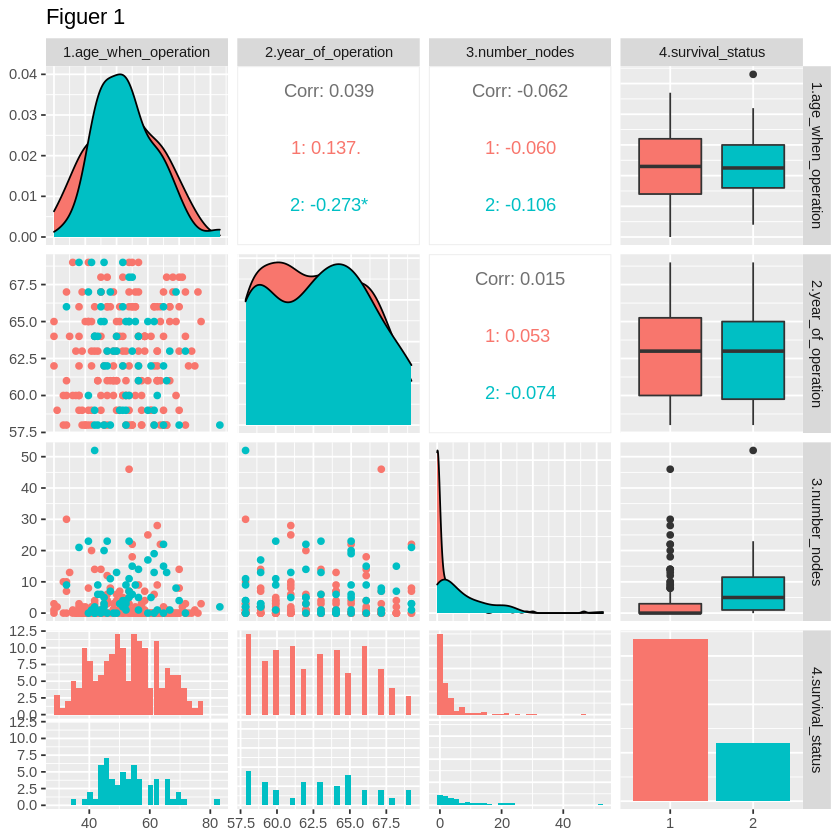

In [9]:
patient_eda <- ggpairs(patient_training, 
                       columns = 1:ncol(patient_training), 
                       ggplot2::aes(colour = survival_status),
                       columnLabels = c("1.age_when_operation", "2.year_of_operation", 
                                        "3.number_nodes", "4.survival_status")) +
               ggtitle("Figuer 1")

patient_eda

**Explanation of plot naming：**

1-4 from left to right and 1-4 from top to bottom
<br> `plot1.1` means the plot of the first left variable and the top variable, which is `age_when_operation` and `age_when_operation`.

**Explore `age_when_operation` variable**
<br>Although the size and position of the red and blue box line diagrams are very similar as seen in `plot4.1`(From the above calculation of the average patient's age of the two survival status can  be numerically seen). It seems that `age_when_operation` and `survival_status` do not have an obvious relationship. However, we find from `plot1.1` that the blue region (`survival_status 2`) has a higher peak than the red region (`survival_status 1`). As well as in `plot1.4` we can see that a small part of the age area exists only in the red area of `survival_status 1` and in the blue area of `survival_status 2` separately (The front part of the x-axis is all red and the back part of the x-axis is all blue). In conclusion, although this relationship is a very obscure week relationship it is undeniable that the blue area(`survival_status 2`) tends to occupy the right position on the x-axis (larger age area). This means that older patients are somewhat more likely to survive less than five years. 

**Explore `number_nodes` variable**
<br> We could clearly see from `plot3.3` that the change in the number of nodes is strongly correlated with `survival_status`. When the number of nodes increases, the survival status is almost all blue, which represents that the patient can only live less than five years. From the `plot4.3` we could see that the height of red box line diagrams is much shorter than blue box line diagrams, and there are some dots above red box line diagrams. It means that `number_nodes` and `survival_status` do have an obvious strong relationship. The `plot3.4` also shows the big difference between `number_nodes` filled with red color and blue color. The red colored nodes takes the domain of whole plot when the years remains to live is longer than 5 years.

#### Performs the data analysis

Create a new K-nearest neighbor model specification insert `tune()` for the `neighbors` argument.

*Assign our answer to an object called `knn_spec`.*

In [15]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

For this project, we will use `age_when_operation` and `number_nodes` to predict `survival_status` (the reason we choose these two variables to predict `survival_status` is shown above). 

To scale and center the data, first, pass the vector and the predictors to the `recipe` function. To scale the predictors, use the `step_scale(all_predictors())` function. To center the predictors, use the `step_center(all_predictors())` function.  

*Assign our answer to an object called `patient_recipe`.*

In [16]:
patient_recipe <- recipe(survival_status ~ age_when_operation + number_nodes, data = patient_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

Choosing 5-fold cross-validation or 10-fold cross-validation is trading off between accuracy and computational power. We think using 5-fold cross-validation is accurate enough to perform on this dataset.

Using a **5-fold cross-validation** , we establish a prediction accuracy for our classifier. 

*Assign our answer to an object called `patient_vfold`.*

In [22]:
patient_vfold <- vfold_cv(patient_training, v = 5, strata = survival_status)

Now, we need to create a `workflow()` analysis that combines `patient_recipe` and our `knn_spec` model specification. 

We will use the `tune_grid` function to fit the model for each value in a range of parameter values. For the `resamples` argument, input the cross-validation `patient_vfold` model we created earlier. The `grid` argument specifies that the tuning should try $X$ amount of values of the number of neighbors $K$ when tuning. For this project, use *10 $K$ values when tuning*. 

Finally, aggregate the mean and standard error by using the `collect_metrics` function.

*Assign our answer to an object called `knn_results`.*

In [23]:
knn_results <- workflow() %>%
add_recipe(patient_recipe) %>%
add_model(knn_spec) %>%
tune_grid(resamples = patient_vfold, grid = 10) %>%
collect_metrics()

Now we are trying to find the best value of the number of neighbors. 

First, from `knn_results`, filter for `accuracy` from the `.metric` column. 

*Assign our answer to an object called `accuracies`.*

Next, create a line plot using the `accuracies` dataset with `neighbors` on the x-axis and the `mean` on the y-axis. 

*Assign our answer to an object called `accuracy_versus_k`.*

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7239614,5,0.02653472,Preprocessor1_Model1
3,accuracy,binary,0.7457971,5,0.01397163,Preprocessor1_Model2
4,accuracy,binary,0.7414493,5,0.01511962,Preprocessor1_Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.7281159,5,0.008218810,Preprocessor1_Model7
13,accuracy,binary,0.7194203,5,0.006929295,Preprocessor1_Model8
14,accuracy,binary,0.7150725,5,0.008445682,Preprocessor1_Model9


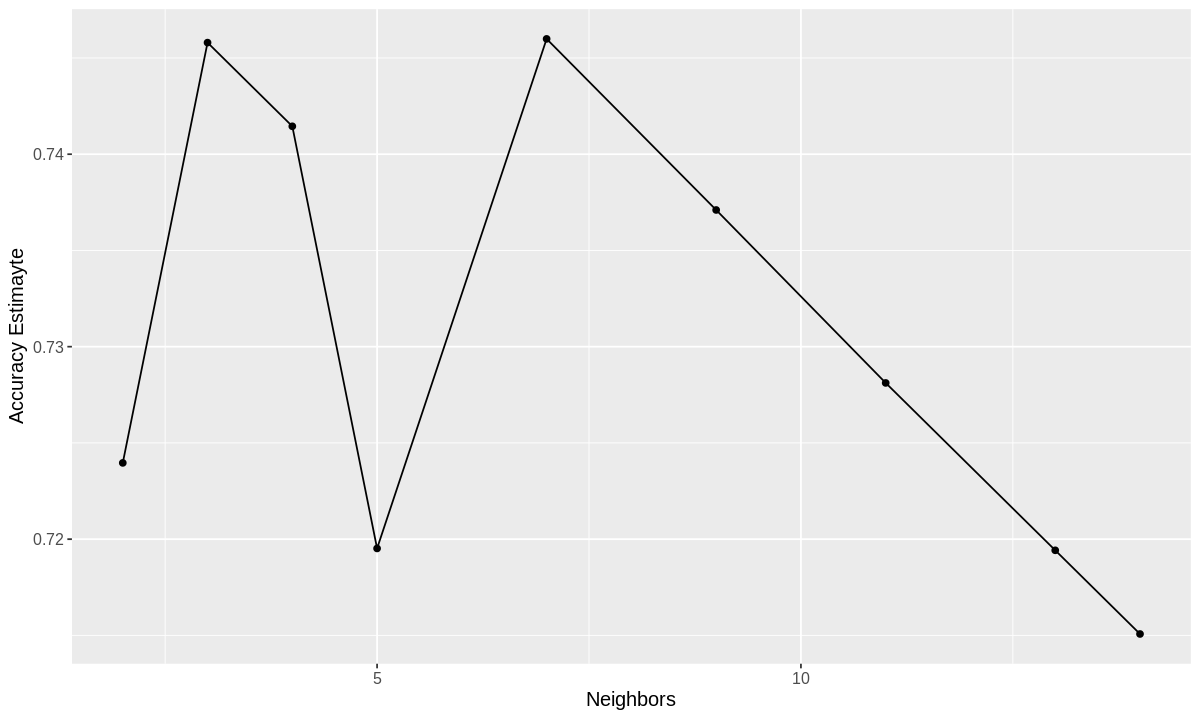

In [24]:
options(repr.plot.width=10, repr.plot.height=6)

accuracies <- knn_results %>%
filter(.metric == "accuracy")
accuracies

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) + 
geom_point() +
geom_line() +
labs(x = "Neighbors", y = "Accuracy Estimayte") +
theme(text = element_text(size = 12))
accuracy_vs_k

From the plot above, we can see that $K = 5$ provides the highest accuracy. So we will use $K = 5$ for our classifier. 

Then we will use the result we get above to create the classifier by specifying that $K = 5$ neighbors and that we want to use the *straight-line* distance. 

In [ ]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
            set_engine("kknn") |>
            set_mode("classification")

Next, train the classifier with the training data set using the `workflow` function. 
*Assign our answer to an object called `knn_fit`*.

In [ ]:
knn_fit <- workflow() %>%
           add_recipe(patient_recipe) %>%
           add_model(knn_spec) %>%
           fit(data = patient_training)

Now that we have created our K-nearest neighbor classifier object, let's predict the accuracy for our test set.

First, pass our fitted model `knn_fit` and the test data `patient_testing` to the `predict` function. Then, use the `bind_cols` function to add the column of predictions to the original test data. 

To get the statistics about the quality of our model, we need to specify the `truth` and `estimate` arguments. In the `truth` argument, we will put `survival_status` into it. In the `estimate` argument, we will put the column name for response variable predictions. 

*Assign our answer to an object called `patient_prediction_accuracy`.*

In [ ]:
patient_prediction_accuracy <- predict(knn_fit, patient_testing) |>
                               bind_cols(patient_testing) |>
                               metrics(truth = survival_status, estimate = .pred_class) |>
                               filter(.metric == "accuracy") 
patient_prediction_accuracy

Also, we can create a confusion matrix by using the `conf_mat` function. Similar to the `metrics` function, we will have to specify the `truth` and `estimate` arguments (the columns' names is just the same as above). 

*Assign our answer to an object called `patient_prediction_mat`*.

In [ ]:
patient_prediction_mat <- predict(knn_fit, patient_testing) |>
                          bind_cols(patient_testing) |>
                          conf_mat(truth = survival_status, estimate = .pred_class)
patient_prediction_mat

#### Creates a visualization of the analysis 

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8)

patient_plot <- patient_data |>
                ggplot(aes(x = age_when_operation, y = number_nodes, color = survival_status)) +
                geom_point() +
                labs(x = "Age of patient at time of operation",
                     y = "Number of positive axillary nodes detected", 
                     color = "Survival status") +
                ggtitle("Figuer 2")

patient_plot

Since the dataset we chose contains so little data and the points are relatively scattered, it is hard to see an obvious relationship. But we could see from the above plot that the red dots tend to be concentrated in the lower left and the blue dots tend to be concentrated in the upper right. It allows us to conclude that with the increase in age(when people did an operation) and the number of positive axillary lymph nodes detected, the survival status tends to become blue, which means patients will live for less than 5 years.

## Discussion

### Summarize what we found

Using the Haberman’s Survival Data Set we made a model that predicts the survival rate of patients
after five years following the surgery.
We used the first two figures to derive conditions for using the age of the patient and the
number of nodes as predictors to predict the survival status for patients after surgery. We divided our data set to training and testing data set. Using 5-fold cross validation on our training dataset, we obtain the value of K that can make the classifier the most accurate one. Then we use the K's value we obtained from above in knn spec's prediction, chosen 5 as the nearest_neighbour. After applying the model to our testing dataset, our model had
76.92308 percentage accuracy. After the final results were obtained, a visual analysis was
created, using 'Age of patient at the time of operation' and 'Number of positive axillary nodes
detected' as the x-axis and y-axis in a plot called patient plot. The plot showed that the patient's
age and the number of axillary nodes affect the patient's survival rate. The greater
the number of axillary nodes, the lower the chance of survival after five years after surgery.
Also the greater the age, the lower the chance of survival after five years after surgery. We
also noticed that the number of positive axillary nodes detected in a patient’s body had a greater
effect on the survival rate compared to the age of the patient at the time of surgery.
In conclusion, the accuracy of our model to predict the survival rate of a cancer patient after five
years following surgery was not very high or accurate, just 76.92308%. This could be a result of
the low correlation between age and survival rate after five years following surgery.
Several other studies use models to predict patients’ survival rates. Using
common scholarly databases, we have found two scholarly articles with a similar process. Delen
and colleagues (2005) predicted patient's survival rate by predicting a model. They used a 10-fold cross-validation procedure, using a sampling technique to divide the data into 10 partitions and
then using 9 of the 10 parts for training and the tenth part for testing. Their model had the highest
accuracy of 93.6% and the lowest accuracy of 89.2%. One of the reasons they achieved this
high accuracy could be because of using 10-fold cross-validation which could make the model
more accurate.
A more recent study conducted by Lotfnezhad and colleagues (2021), used modelling to predict
The survival rate of breast cancer patients over a five-year period. They used age, cancer stage,
tumour size, ethnicity, marital status, and number of nodes as predictors for their model. Their
model achieved an accuracy of 84.42%. a reason for this high accuracy could be considering a
variety of factors as predictors that each could have a great effect on the survival rate.

### Findings and Expected findings 

With our model we are trying to predict the patient's survival status based on the patient's age, year of
operation, and the number of positive axillary nodes detected in the patient's body. We expected the
patient's age to be a significant statistic. We expected older patients to have a lower chance of survival.
Also, we expected the number of positive axillary lymph nodes detected in a patient, to affect the
survival rate. We were expected to see a decline in the chance of patients’ survival as the number of
positive axillary lymph nodes detected in a patient body increased. Our findings do support our
expectations. As the patients' age goes higher at the time of the surgery, the older the patient, the survival rate gets lower. Also, as positive axillary lymph nodes detected in a patient body increase, the
survival rate decreases. We found the number of positive axillary lymph nodes detected in a patient
body to be a more significant factor in determining the survival rate.

### Impacts 

There are always some risks involved in any operation. Risks such as infection, anesthesia health effects,
unexpected events during surgery, and after-surgery care. If there is a chance of mortality within five
years after the operation, patients might not be willing to go through with the surgery. Some patients
might question whether it's safe to go through with surgery and accept all the risks if there is a chance
of mortality just five years down the road. It would be very useful to be able to assist patients and help
them through the process if we could assess the mortality rate after five years following the surgery. It also can help doctors assess whether to prescribe surgery for their patients knowing their chance of
survival with or without surgery. By using the patient's age, year of operation, and number of positive
axillary lymph nodes, we can predict patients’ survival status and give the patients the opportunity and
ability to make a conscious decision whether they want to go through surgery and accept all the
risks that may follow or not. It would also allow doctors to make a wiser choice when suggesting an operation or
advising against it when they have more knowledge about the outcome and survival rate of their patients.

### Future questions

The above data analysis only uses the number of positive axillary lymph nodes detected, age, and the
year of operation as predictive factors. Although our model cannot predict mortality after five years
following the surgery with high certainty, it can be used as background knowledge for future studies. In
future studies, we can use cancer mutation, as another relevant statistic to predict survival rates.
Cancers that mutate will stop working normally, grow out of control and even sometimes can travel
through the blood and affect other organs and parts of patients. We can ask, how will cancer mutation affect
the survival rate of patients after five years following the surgery? Another area for future research
could be finding the statistic that has the highest effect on survival status. This could be very significant
as it would help medications to be more targeted and it might help increase survival rates significantly.
We can ask which factor, age, mutation, or number of nodes, will have the greatest effect on the patients
The survival rate after five years following the surgery?

## References

* Delen, D., Walker, G., & Kadam, A. (2005). Predicting breast cancer survivability: a comparison of
three data mining methods. Artificial intelligence in medicine, 34(2), 113–127.
https://doi.org/10.1016/j.artmed.2004.07.002
* Lotfnezhad Afshar, H., Jabbari, N., Khalkhali, H. R., & Esnaashari, O. (2021). Prediction of Breast
Cancer Survival by Machine Learning Methods: An Application of Multiple
Imputation. Iranian journal of public health, 50(3), 598–605.
https://doi.org/10.18502/ijph.v50i3.5606